**Updated**: 08.08.2021

In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import json
import tldextract

from colors import Colors

%matplotlib inline

In [2]:
connection = sq.connect("./measurements.db")
connection.row_factory = sq.Row

In [3]:
certs = pd.read_csv("certs.csv", converters={"info":json.loads}, header = None, names = ["ip", "protocol", "port", "info"])
quic_certs = certs
quic_certs["common_name"] = quic_certs["info"].apply(lambda info: tldextract.extract(info["CommonName"]).registered_domain)

### All QUIC Resolver

<AxesSubplot:title={'center':'quic_handshake_duration'}, xlabel='ip'>

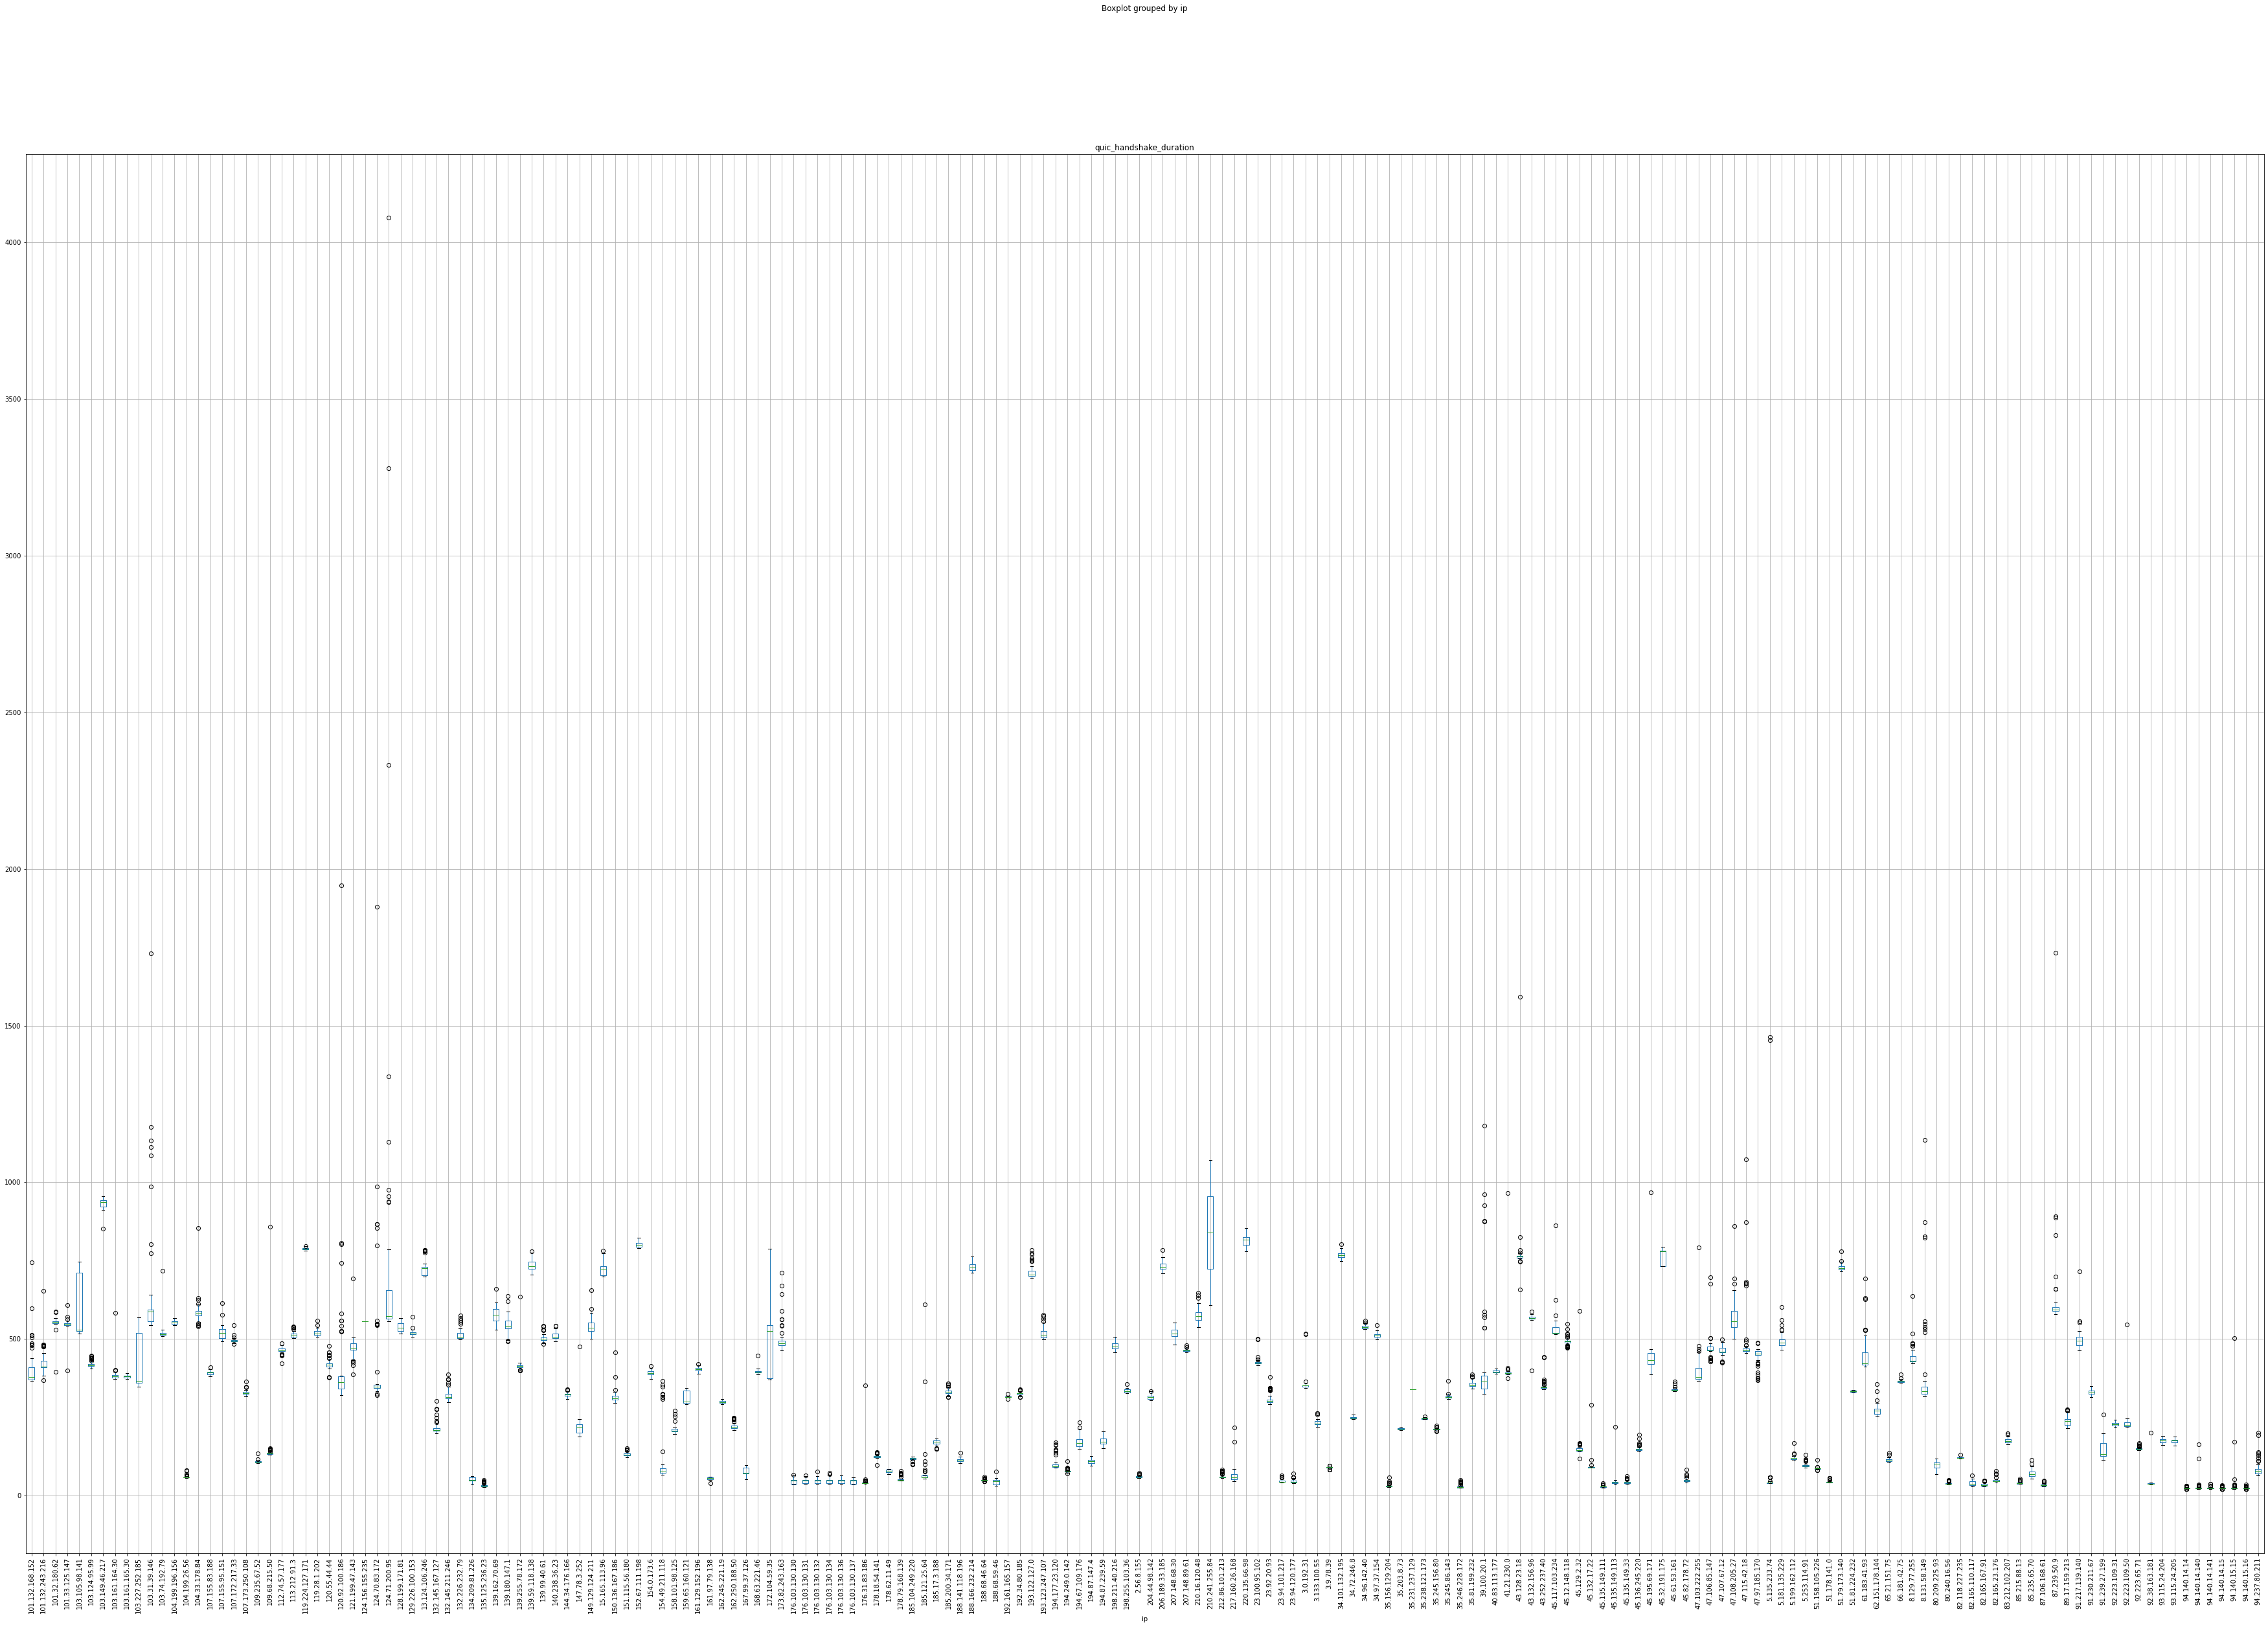

In [60]:
def getSetupTime():
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming".format(protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    sql = """
    SELECT ip, protocol, q_ui_c_handshake_duration / 1000000 as quic_handshake_duration, tcp_handshake_duration / 1000000 as tcp_handshake_duration, tls_handshake_duration / 1000000 as tls_handshake_duration, port FROM dns_measurements measurement
    WHERE measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
    """.format(*statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

setupTime = getSetupTime()
setupTime["tls_total"] = setupTime.apply(lambda row: row["tcp_handshake_duration"] + row["tls_handshake_duration"] if row["protocol"] == "tls" or row["protocol"] == "https" else None, axis = 1)
quicSetupTime = setupTime[setupTime["protocol"] == "quic"]
quicSetupTime.boxplot(by = "ip", figsize = (60, 40), rot = 90, column = "quic_handshake_duration")

In [62]:
largestVar = setupTime.groupby("ip")["quic_handshake_duration"].var().reset_index(name = "var").nlargest(20, "var")
smallestVar = setupTime.groupby("ip")["quic_handshake_duration"].var().reset_index(name = "var").nsmallest(20, "var")

### Largest Variance QUIC Resolver

<AxesSubplot:title={'center':'tcp_handshake_duration'}, xlabel='common_name'>

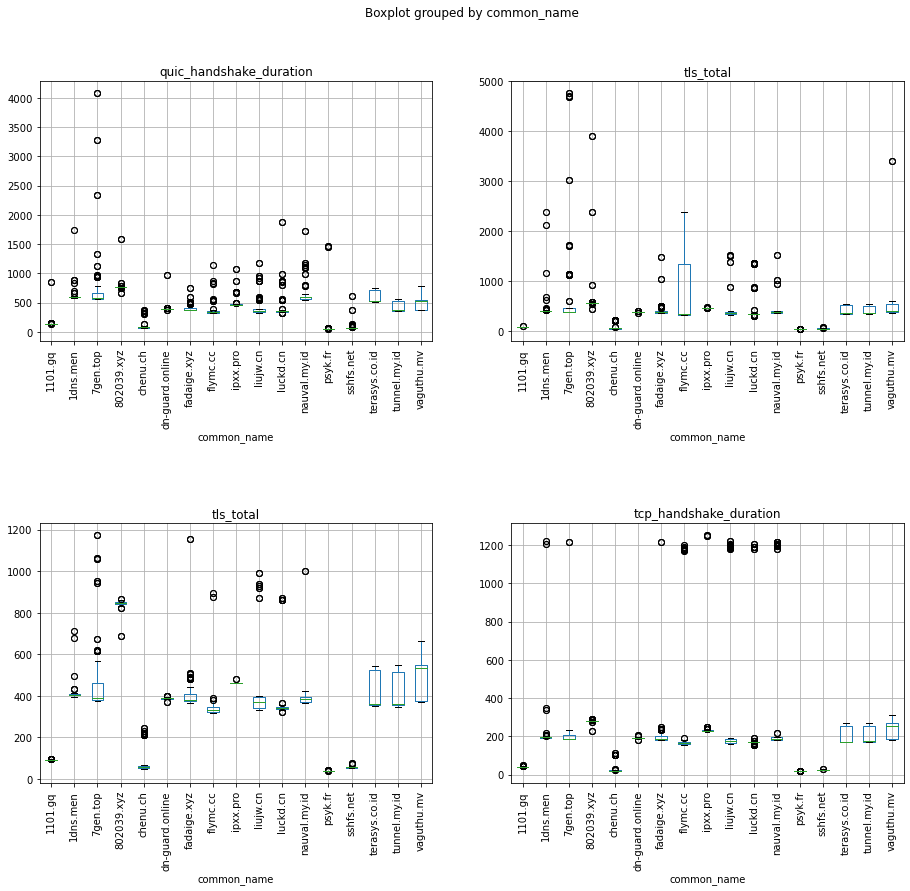

In [66]:
setupTimeLargest = setupTime[setupTime["ip"].isin(largestVar["ip"].unique())]
largestValues = pd.merge(setupTimeLargest, quic_certs, on = ["ip"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 13))
fig.subplots_adjust(hspace=0.7)
largestValues[largestValues["protocol_x"] == "quic"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[0, 0], column = ["quic_handshake_duration"])
largestValues[largestValues["protocol_x"] == "tls"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[0, 1], column = ["tls_total"])
largestValues[largestValues["protocol_x"] == "https"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[1, 0], column = ["tls_total"])
largestValues[largestValues["protocol_x"] == "tcp"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[1, 1], column = ["tcp_handshake_duration"])

In [117]:
def mergeAll(items):
    temp = items[0]
    for i in range(1, len(items)):
        temp = pd.merge(temp, items[i], on = ["common_name"])
    return temp

#### Variances Compared

In [120]:
tcp = largestValues[largestValues["protocol_x"] == "tcp"].groupby("common_name")["tcp_handshake_duration"].var().div(1000).reset_index(name = "tcp")
tls = largestValues[largestValues["protocol_x"] == "tls"].groupby("common_name")["tls_total"].var().div(1000).reset_index(name = "tls")
https = largestValues[largestValues["protocol_x"] == "https"].groupby("common_name")["tls_total"].var().div(1000).reset_index(name = "https")
quic = largestValues[largestValues["protocol_x"] == "quic"].groupby("common_name")["quic_handshake_duration"].var().div(1000).reset_index(name = "quic")

mergeAll([tcp, tls, https, quic])

,common_name,tcp,tls,https,quic
0,1101.gq,0.001919,0.003151,0.004409,8.800038
1,1dns.men,35.145010,123.734270,3.241318,25.473593
2,7gen.top,17.578243,1069.275658,38.321928,371.969447
3,802039.xyz,0.057421,241.072874,0.489232,11.842662
4,chenu.ch,0.796039,3.075490,3.232511,7.732268
5,dn-guard.online,0.008348,0.024571,0.017591,5.552074
6,fadaige.xyz,17.713358,28.366584,11.145367,4.202117
7,flymc.cc,114.189853,405.279069,11.163290,24.654683
8,ipxx.pro,35.367563,0.015559,0.045088,11.191106
9,liujw.cn,125.321048,65.759524,31.928592,31.552359


#### Sample Size

In [104]:
counts = largestValues.groupby(["protocol_x", "common_name"]).size().reset_index(name = "size")
tcp = counts[counts["protocol_x"] == "tcp"].drop("protocol_x", axis = 1)
tcp.columns = ["common_name", "tcp"]
tls = counts[counts["protocol_x"] == "tls"].drop("protocol_x", axis = 1)
tls.columns = ["common_name", "tls"]
https = counts[counts["protocol_x"] == "https"].drop("protocol_x", axis = 1)
https.columns = ["common_name", "https"]
quic = counts[counts["protocol_x"] == "quic"].drop("protocol_x", axis = 1)
https.columns = ["common_name", "quic"]
mergeAll([tcp, tls, https, quic])

,common_name,tcp,tls,quic,size
0,1101.gq,177,177,177,177
1,1dns.men,116,116,106,116
2,7gen.top,177,171,159,177
3,802039.xyz,177,177,177,177
4,chenu.ch,177,177,177,177
5,dn-guard.online,177,177,177,177
6,fadaige.xyz,177,177,174,177
7,flymc.cc,112,28,108,118
8,ipxx.pro,171,48,18,177
9,liujw.cn,174,171,138,177


### Smallest Variance QUIC Resolver

<AxesSubplot:title={'center':'tcp_handshake_duration'}, xlabel='common_name'>

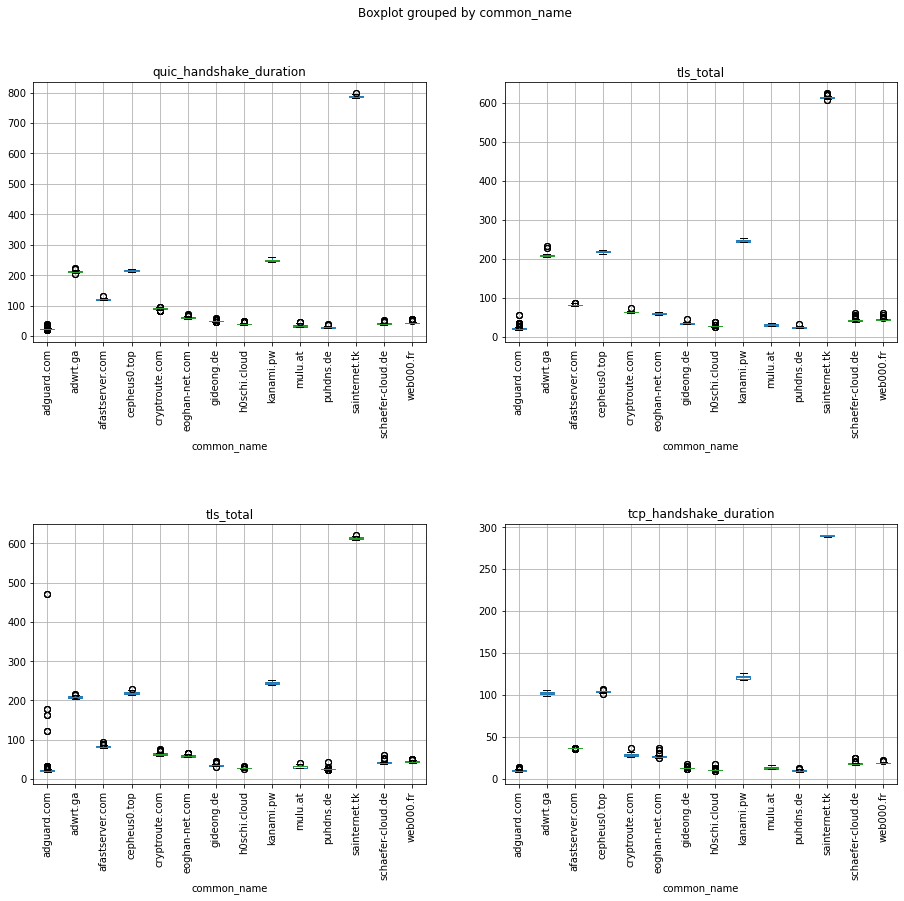

In [121]:
setupTimeSmallest = setupTime[setupTime["ip"].isin(smallestVar["ip"].unique())]
smallestValues = pd.merge(setupTimeSmallest, quic_certs, on = ["ip"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15, 13))
fig.subplots_adjust(hspace=0.7)
smallestValues[smallestValues["protocol_x"] == "quic"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[0, 0], column = ["quic_handshake_duration"])
smallestValues[smallestValues["protocol_x"] == "tls"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[0, 1], column = ["tls_total"])
smallestValues[smallestValues["protocol_x"] == "https"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[1, 0], column = ["tls_total"])
smallestValues[smallestValues["protocol_x"] == "tcp"].boxplot(by = "common_name", figsize = (15, 10), rot = 90, ax = axes[1, 1], column = ["tcp_handshake_duration"])

#### Variances Compared

In [123]:
tcp = smallestValues[smallestValues["protocol_x"] == "tcp"].groupby("common_name")["tcp_handshake_duration"].var().reset_index(name = "tcp")
tls = smallestValues[smallestValues["protocol_x"] == "tls"].groupby("common_name")["tls_total"].var().reset_index(name = "tls")
https = smallestValues[smallestValues["protocol_x"] == "https"].groupby("common_name")["tls_total"].var().reset_index(name = "https")
quic = smallestValues[smallestValues["protocol_x"] == "quic"].groupby("common_name")["quic_handshake_duration"].var().reset_index(name = "quic")

mergeAll([tcp, tls, https, quic])

,common_name,tcp,tls,https,quic
0,adguard.com,0.503262,9.579147,1075.482485,4.586165
1,adwrt.ga,1.812018,20.198575,6.620570,9.494029
2,afastserver.com,0.275616,3.309707,6.088983,5.763675
3,cepheus0.top,1.248074,5.955508,8.378274,7.073575
4,cryptroute.com,2.708783,5.112481,8.110169,10.213983
5,eoghan-net.com,3.678351,4.945493,5.292758,10.452619
6,gideong.de,0.487096,4.155624,5.651002,5.756741
7,h0schi.cloud,1.213405,5.025809,1.750770,10.193760
8,kanami.pw,2.329738,7.452042,8.208398,12.629815
9,mulu.at,1.430663,4.573382,5.962442,12.350154


#### Sample Size

In [124]:
counts = smallestValues.groupby(["protocol_x", "common_name"]).size().reset_index(name = "size")
tcp = counts[counts["protocol_x"] == "tcp"].drop("protocol_x", axis = 1)
tcp.columns = ["common_name", "tcp"]
tls = counts[counts["protocol_x"] == "tls"].drop("protocol_x", axis = 1)
tls.columns = ["common_name", "tls"]
https = counts[counts["protocol_x"] == "https"].drop("protocol_x", axis = 1)
https.columns = ["common_name", "https"]
quic = counts[counts["protocol_x"] == "quic"].drop("protocol_x", axis = 1)
https.columns = ["common_name", "quic"]
mergeAll([tcp, tls, https, quic])

,common_name,tcp,tls,quic,size
0,adguard.com,944,944,944,1888
1,adwrt.ga,177,177,177,177
2,afastserver.com,177,177,177,177
3,cepheus0.top,177,177,177,177
4,cryptroute.com,177,177,177,177
5,eoghan-net.com,177,177,177,177
6,gideong.de,177,177,177,177
7,h0schi.cloud,177,177,177,177
8,kanami.pw,177,177,177,177
9,mulu.at,177,177,177,177


### All QUIC Resolver with Common Name

<AxesSubplot:title={'center':'quic_handshake_duration'}, xlabel='common_name'>

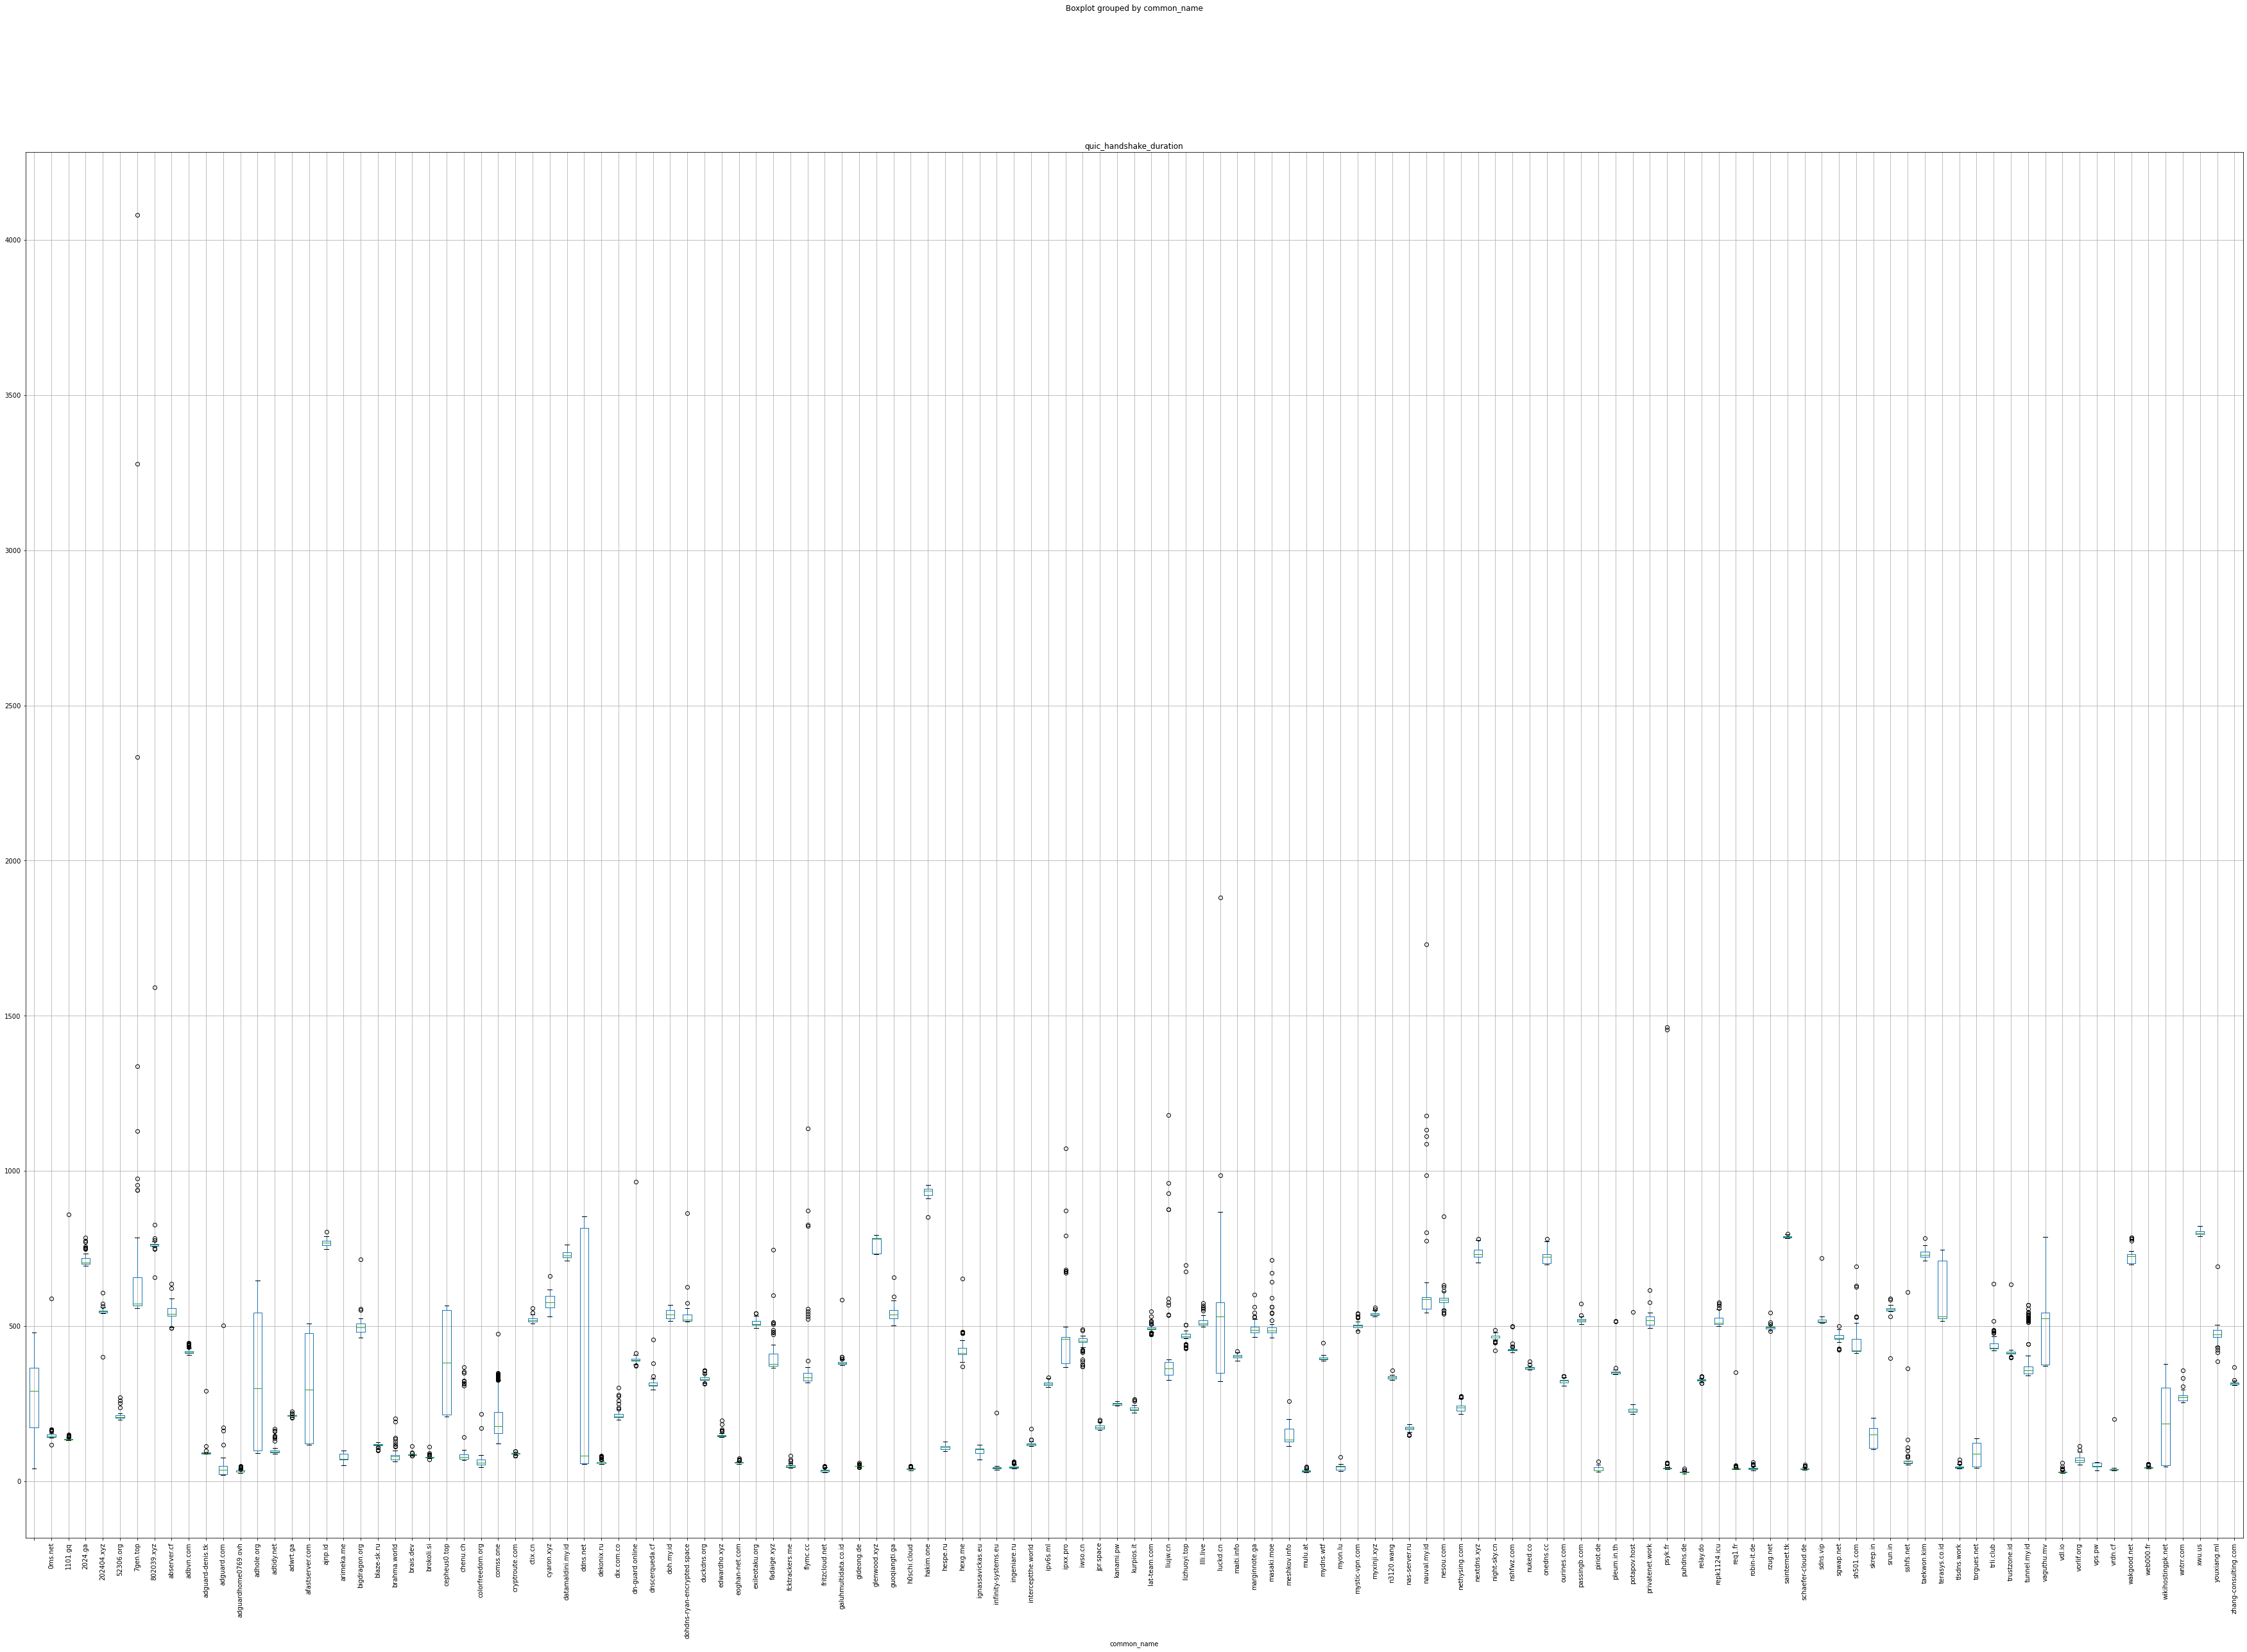

In [12]:
test = pd.merge(setupTime, quic_certs, on = ["ip", "port"])
test.boxplot(by = "common_name", figsize = (60, 40), rot = 90, column = "quic_handshake_duration")